In [1]:
import numpy as np
import cvxpy as cp
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
#warnings.filterwarnings("ignore")

# Definition of data

In [154]:
T = 24
N = 6

generation_costs = np.array([15, 20, 15, 20, 30, 25.])
startup_costs = np.array([75, 100, 75, 100, 100, 125.])
shutdown_costs = np.array([7.5, 10.0, 7.5, 10.0, 10.0, 12.5])
running_costs = np.array([10, 5, 10, 10, 10, 10.])

capacity = np.array([10, 5, 10, 10, 20, 30.])
ramp_up_rate = np.array([2, 5, 2, 5, 10, 5.])
ramp_down_rate = np.array([2, 5, 2, 5, 10, 5.])

initial_state = np.array([1, 0,0, 0, 0, 0])

In [155]:
rt_bar = np.array([15.2, 16.4, 16.1, 10.9, 14.8, 7.6, 15.6, 5.5, 9.2, 5.7, 1.5, 12.4, 10.4, 4.8, 14.3, 0.5, 6.6, 5.7, 11.5, 11.9, 2.8, 7.3, 6.7, 9.7])
rt_hat = 0.6*np.ones_like(rt_bar)
dt = np.array([21.3, 21.4, 17.8, 20.9, 15.5, 17.6, 20.2, 23.8, 27.7, 30.1, 35.4, 39.4, 43.2, 47.0, 49.3, 51.5, 52.6, 50.3, 47.0, 43.1, 38.8, 33.2, 28.6, 24.3])

# Question 3.5

In [156]:
Tup = 3
Tdown = 2

In [170]:
# Def variables
# Primal variables
x = cp.Variable((T, N), boolean = True)
u = cp.Variable((T, N), boolean = True)
v = cp.Variable((T, N), boolean = True)

# Dual variables
phi1 = cp.Variable((T))
phi2 = cp.Variable((T))
lambda1 = cp.Variable((T))
lambda2 = cp.Variable((T))
lambda3 = cp.Variable((T))
lambda4 = cp.Variable((T))
mu1 = cp.Variable((T))
mu2 = cp.Variable((T))
mu3 = cp.Variable((T))
mu4 = cp.Variable((T))

# Parametric variables
a = cp.Variable((T, N))
b = cp.Variable((T, N))
c = cp.Variable((T, N))

In [227]:
# Objective
obj = cp.Minimize(sum(startup_costs@u.T + shutdown_costs@v.T + running_costs@x.T + c@running_costs.T) + (rt_bar - rt_hat).T@phi1 + (rt_bar + rt_hat).T@phi2)

In [228]:
# Def constraints
cons = []

# Dual constraints ------------------------------------------------
for t in range(T-1):
    cons.append(phi1[t] + phi2[t] >= (a[t,:] + b[t+1,:]).T@running_costs)

cons.append(phi1[-1] + phi2[-1] >= a[-1,:].T@running_costs)    
cons.append(phi1 <= 0)
cons.append(phi2 >= 0)

# Constraint 3b --------------------------------------------------
for t in range(T):
    cons.append(sum(a[t,:]) == -1)
    cons.append(sum(b[t,:]) == 0)
    cons.append(sum(c[t,:]) == dt[t])

# For constraint 3c ----------------------------------------------
#----------------------------
for t in range(1,T):
    for i in range(N):      
        cons.append(0 <= (rt_bar[t] - rt_hat[t])*lambda1[t] + (rt_bar[t] + rt_hat[t])*lambda2[t] +
                   (rt_bar[t-1] - rt_hat[t-1])*lambda3[t] + (rt_bar[t-1] + rt_hat[t-1])*lambda4[t] + c[t,i])
        cons.append(lambda1[t] + lambda2[t] <= a[t,i])
        cons.append(lambda3[t] + lambda4[t] <= b[t,i])

for i in range(N):
    cons.append(0 <= (rt_bar[0]-rt_hat[0])*lambda1[0] + (rt_bar[0]+rt_hat[0])*lambda2[0] + c[0,i])
    cons.append(lambda1[0] + lambda2[0] <= a[0,i])
    cons.append(lambda3[0] + lambda4[0] <= b[0,i])

    

cons.append(lambda1 >= 0)
cons.append(lambda2 <= 0)
cons.append(lambda3 >= 0)
cons.append(lambda4 <= 0)
#------------------------------------
for t in range(1,T):
    for i in range(N):
        cons.append(x[t,i]*capacity[i] >= (rt_bar[t] - rt_hat[t])*mu1[t] + (rt_bar[t] + rt_hat[t])*mu2[t] + 
                    (rt_bar[t-1] - rt_hat[t-1])*mu3[t] + (rt_bar[t-1] + rt_hat[t-1])*mu4[t] + c[t,i])
        cons.append(mu1[t] + mu2[t] >= a[t,i])
        cons.append(mu3[t] + mu4[t] >= b[t,i])

for i in range(N):
    cons.append(x[0,i]*capacity[i] >= (rt_bar[0] - rt_hat[0])*mu1[0] + (rt_bar[0] + rt_hat[0])*mu2[0] + c[0,i])
    cons.append(mu1[0] + mu2[0] >= a[0,i])
    cons.append(mu3[0] + mu4[0] >= b[0,i])
    
cons.append(mu1 <= 0)
cons.append(mu2 >= 0)
cons.append(mu3 <= 0)
cons.append(mu4 >= 0)
#  Constraints 2d - 2h -------------------------------------------

# For time 0
cons.append(x[0,:] == initial_state)
cons.append(u[0,:] == 0)
cons.append(v[0,:] == 0)

#Rest of time periods
for t in range(1, T):
    cons.append(x[t-1,:] - x[t,:] + u[t,:] >= 0) # Write smt here
    cons.append(x[t,:] - x[t-1,:] + v[t,:] >= 0) # Write smt here

# For each t except first and last
for t in range(1, T-1):
    tau_up = min(t + Tup, T)  # Calculate the max T_up
    for tau_u in range(t+1, tau_up):
        cons.append(x[t,:] - x[t-1,:] <= x[tau_u,:]) # T up cons
        
    tau_down = min(t + Tdown, T)  # Calculate max T_down
    for tau_d in range(t+1, tau_down):
        cons.append(x[t-1,:] - x[t,:] <= 1 - x[tau_d,:]) # T down cons
        


In [229]:
# Sol

# Measure time
start = time.time() # Time starts

# Solve problem
problem = cp.Problem(obj, cons)
problem.solve(solver = 'ECOS_BB')

end = time.time() # Time ends

print('Objective value: ' + str(obj.value))
print('Time elapsed: ' + str(end - start) + ' seconds')

Objective value: None
Time elapsed: 1.1175706386566162 seconds


In [ ]:
print(a.value)

AttributeError: 'NoneType' object has no attribute 'T'

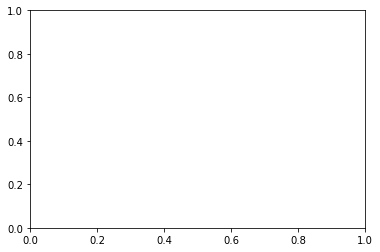

In [141]:
# X plot
fig, ax2 = plt.subplots()
ax2.imshow(x.value.T, interpolation='nearest', aspect='auto')
ax2.set_xlabel('Time (h)')
ax2.set_ylabel('Generator')
ax2.set_title('$x_i^t$')
ax2.set_yticklabels(['1', '1', '3', '5'])

# Binary colorbar
plt.colorbar(ax2.imshow(x.value.T, interpolation='nearest', aspect='auto'))

In [57]:
lol = np.random.rand(24, 6)

sum(lol)


array([13.4850575 , 12.87983145, 11.23832558, 12.3284974 , 13.15474142,
       13.54503505])

In [104]:
b.value

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-8.91088757e-15, -8.91088757e-15, -8.91088757e-15,
        -8.91088757e-15, -8.91088757e-15, -8.91088757e-15],
       [-1.61611041e-13, -1.61611041e-13, -1.61611041e-13,
        -1.61611041e-13, -1.61611041e-13, -1.61611041e-13],
       [-1.88472977e-15, -1.88472977e-15, -1.88472977e-15,
        -1.88472977e-15, -1.88472977e-15, -1.88472977e-15],
       [-1.43131449e-12, -1.43131449e-12, -1.43131449e-12,
        -1.43131449e-12, -1.43131449e-12, -1.43131449e-12],
       [-1.64106201e-15, -1.64106201e-15, -1.64106201e-15,
        -1.64106201e-15, -1.64106201e-15, -1.64106201e-15],
       [-4.29193773e-15, -4.29193773e-15, -4.29193773e-15,
        -4.29193773e-15, -4.29193773e-15, -4.29193773e-15],
       [-5.15918602e-16, -5.15918602e-16, -5.15918602e-16,
        -5.15918602e-16, -5.15918602e-16, -5.15918602e-16],
       [-1.76800320e-16, -1.76800320e-16, -1.768